In [136]:
import numpy as np
import pandas as pd
import scanpy as sc 

adata = sc.read_h5ad("dataset_co_mo.h5ad")
#lr_genes = pd.read_csv("dataset_co_mo.csv", header=0)  # Or header=True if you're on an older pandas version

In [137]:
# Extract source and receiver genes efficiently
gl_source = ['TGFBR2', 'SMAD3', 'HIF1A', 'PDGFB'] # All values from the first column
gl_recv =['TGFB1', 'IL6', 'PDGFRB']  # All values from the second column

ict1 = adata.obs["BatchID"] == "Cancer Cells (Mo)"
ict2 = adata.obs["BatchID"] == "Fibroblasts (Mo)" 
adata_ct1 = adata[ict1, gl_source]
adata_ct2 = adata[ict2, gl_recv]
print(adata_ct1)
print(adata_ct2)

View of AnnData object with n_obs × n_vars = 2364 × 4
    obs: 'CellID', 'BatchID', 'ClusterID', 'CellType', 'CellCycle'
View of AnnData object with n_obs × n_vars = 2788 × 3
    obs: 'CellID', 'BatchID', 'ClusterID', 'CellType', 'CellCycle'


In [138]:
Xct1 = adata_ct1.X.copy()
Xct2 = adata_ct2.X.copy()
Xct1 = Xct1.toarray()
Xct2 = Xct2.toarray()
# Compute cell percentace of cell type 1 count matrix
Xct1p = np.sum(Xct1>0, axis=0)/len(Xct1[:,0])
Xct2p = np.sum(Xct2>0, axis=0)/len(Xct2[:,0])

print("CT1 Percentages:", Xct1p)
print("CT2 Percentages:", Xct2p)

CT1 Percentages: [0.36759729 0.8071066  0.89932318 0.09898477]
CT2 Percentages: [0.42969871 0.42898135 0.29196557]


In [139]:
# Scale the data from 0 to 1 to -pi/2 to pi/2 | 2*pi or pi?
ct1_percentages = (Xct1p-0.5) * np.pi*2*0.9
ct2_percentages = (Xct2p-0.5) * np.pi*2*0.9
#ct1_percentages = (Xct1p-0.5) * np.pi
#ct2_percentages = (Xct2p-0.5) * np.pi
# Display the resulting scaled data
print("Scaled ct1_data:\n", ct1_percentages)
print("Scaled ct2_data:\n", ct2_percentages)

Scaled ct1_data:
 [-0.74871967  1.7366469   2.25811939 -2.26768769]
Scaled ct2_data:
 [-0.39754444 -0.40160101 -1.17640701]


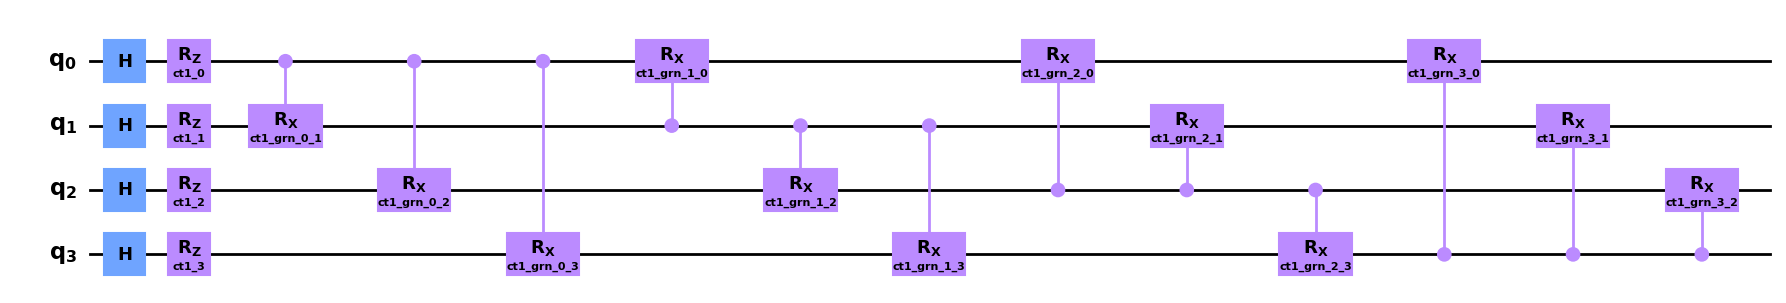

In [140]:
import matplotlib.pyplot as plt
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
import numpy as np

ng_ct1 = len(gl_source)


ansatz_grn_ct1 = QuantumCircuit(ng_ct1, name="CT1_GRN_Ansatz")

params_ct1 = [Parameter(rf'ct1_{i}') for i in range(ng_ct1)]
# Apply Hadamard gates and RY rotations (gene activation probabilities)
for i in range(ng_ct1):
    ansatz_grn_ct1.h(i)
    ansatz_grn_ct1.rz(params_ct1[i], i)
    #ansatz_grn_ct1.rz(params_ct1[i], i)

# # # Activation layer | NOT WORKING...
# act_ct1 = [Parameter(rf'act_ct1_{i}') for i in range(ng_ct1)]
# for i in range(ng_ct1):
#     ansatz_grn_ct1.ry(act_ct1[i], i)

for i in range(ng_ct1):
    for j in range(ng_ct1):
        if i != j:
            param_name = f'ct1_grn_{i}_{j}'
            param = Parameter(param_name)
            ansatz_grn_ct1.crx(param, i, j) # Brings only positive additions in the pdf
            #ansatz_grn_ct1.cry(param, i, j) 


ansatz_grn_ct1.draw(output="mpl", style="clifford", fold=40)

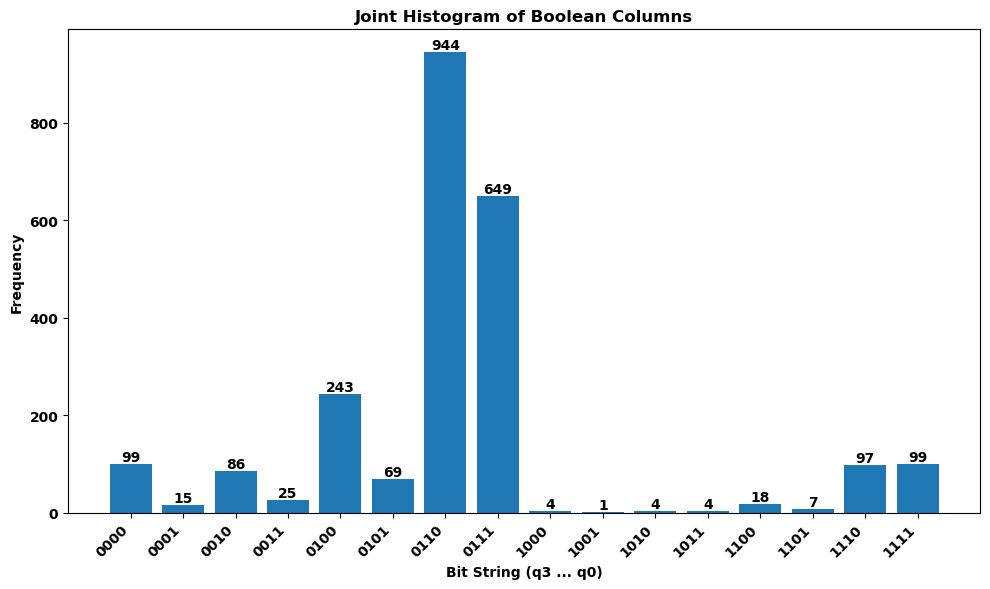

Joint Counts: Counter({'0110': 944, '1110': 649, '0010': 243, '0000': 99, '1111': 99, '0111': 97, '0100': 86, '1010': 69, '1100': 25, '0011': 18, '1000': 15, '1011': 7, '0101': 4, '1101': 4, '0001': 4, '1001': 1})
Bit Strings: ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [141]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def create_joint_histogram(Xct1bool):
    """
    Creates a joint histogram of boolean columns from a NumPy array.
    """
    num_cols = Xct1bool.shape[1]
    joint_counts = Counter()
    bit_strings = set()

    for row in Xct1bool:
        bit_string = "".join(["1" if val else "0" for val in row])
        joint_counts[bit_string] += 1
        bit_strings.add(bit_string)

    return joint_counts, sorted(list(bit_strings))


def plot_joint_histogram(joint_counts, num_qubits, reverse_bits=False):
    """Plots the joint histogram, accounting for potential bit reversal."""
    
    all_bit_strings = [''.join(format(i, f'0{num_qubits}b')) for i in range(2**num_qubits)]
    
    counts = []
    mapped_bit_strings = []

    for bit_string in all_bit_strings:
        if reverse_bits:
            reversed_string = bit_string[::-1]  # Reverse bit order
            count_value = joint_counts.get(bit_string, 0)  # Extract count from original order
            mapped_bit_strings.append(reversed_string)  # Assign to reversed bit string
        else:
            count_value = joint_counts.get(bit_string, 0)
            mapped_bit_strings.append(bit_string)  # Keep regular order

        counts.append(count_value)

    # Sort bit strings by Hamming weight (count of '1's), then numerically
    sorted_pairs = sorted(zip(mapped_bit_strings, counts), key=lambda x: int(x[0], 2))

    # Unzip the sorted pairs
    sorted_bit_strings, sorted_counts = zip(*sorted_pairs)

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_bit_strings, sorted_counts)

    plt.xlabel(f"Bit String (q{num_qubits-1} ... q0)")
    plt.ylabel("Frequency")
    plt.title("Joint Histogram of Boolean Columns")
    plt.xticks(rotation=45, ha="right")

    for i, count in enumerate(counts):
        plt.text(mapped_bit_strings[i], count, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Example Usage (assuming Xct1 is defined):
Xct1bool = Xct1 > 0  # Create boolean array

joint_counts, bit_strings = create_joint_histogram(Xct1bool)

num_qubits = Xct1bool.shape[1]  # Get the number of qubits (important!)
plot_joint_histogram(joint_counts, num_qubits, reverse_bits=True)  # Pass num_qubits

print("Joint Counts:", joint_counts)
print("Bit Strings:", bit_strings)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from qiskit.quantum_info import SparsePauliOp

def create_interaction_observable_from_histogram(joint_counts, num_features, min_ones=2, standardize=False):
    """Creates a SparsePauliOp from joint histogram counts, 
       considering interactions with a minimum number of '1's.
    Args:
        joint_counts: A Counter object from create_joint_histogram.
        num_features: The total number of qubits.
        min_ones: The minimum number of '1's required in a bit string 
                  for the interaction to be included.
        standardize: If True, standardizes the counts before calculating strengths.
    Returns:
        A SparsePauliOp observable.
    """
    interaction_strength_list = []

    # Prepare counts for standardization if needed
    counts_array = np.array(list(joint_counts.values()))
    if standardize:
        mean_count = np.mean(counts_array)
        std_count = np.std(counts_array)
        if std_count == 0:  # Handle case where all counts are the same
            standardized_counts = np.zeros_like(counts_array)
        else:
            standardized_counts = (counts_array - mean_count) / std_count
        
        # Create a dictionary to map bitstrings to standardized counts
        bitstring_to_std_count = dict(zip(joint_counts.keys(), standardized_counts))

    for bit_string, count in joint_counts.items():
        num_ones = bit_string.count('1')  # Count the number of '1's

        if num_ones >= min_ones:  # Consider only if at least min_ones '1's are present
            nodes = tuple(i for i, bit in enumerate(bit_string) if bit == '1')
            
            if standardize:
                strength = -bitstring_to_std_count[bit_string]  # Use standardized count
            else:
                strength = -count  # Use original count

            pauli_string = ""
            for i in range(num_features):
                if i in nodes:
                    pauli_string += "Z"
                else:
                    pauli_string += "I"
            interaction_strength_list.append((pauli_string, strength))

    interaction_observable = SparsePauliOp.from_list(interaction_strength_list)
    return interaction_observable

num_features = Xct1bool.shape[1]  # Get the number of features dynamically

interaction_observable = create_interaction_observable_from_histogram(joint_counts, num_features, min_ones = 2, standardize=False)
print("Interaction observable from histogram:", interaction_observable)

Interaction observable from histogram: SparsePauliOp(['IZZI', 'ZZZZ', 'ZZZI', 'IZZZ', 'ZIZI', 'ZZII', 'IIZZ', 'IZIZ', 'ZZIZ', 'ZIIZ', 'ZIZZ'],
              coeffs=[-944.+0.j,  -99.+0.j, -649.+0.j,  -97.+0.j,  -69.+0.j,  -25.+0.j,
  -18.+0.j,   -4.+0.j,   -4.+0.j,   -1.+0.j,   -7.+0.j])


In [170]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

estimator = StatevectorEstimator()

# --- Create the FULL parameter dictionary BEFORE optimization ---
def create_parameter_dictionaries(combined_qc, ct1_percentages):
    """Creates static and variable parameter dictionaries."""

    # Get Hadamard parameters
    params_ct = [param for param in combined_qc.parameters if 'ct1_' in param.name or 'ct2_' in param.name 
                                                            and 'grn' not in param.name 
                                                            and 'lr' not in param.name
                                                            and 'act' not in param.name] #Added conditions

    static_params = {}
    for i, val in enumerate(ct1_percentages):
        static_params[params_ct[i]] = val

    variable_params = [param for param in combined_qc.parameters if param not in static_params]
    return static_params, variable_params


static_params, variable_params = create_parameter_dictionaries(ansatz_grn_ct1, ct1_percentages)

print("Static Parameters:", static_params)
print("Variable Parameters:", variable_params)


Static Parameters: {Parameter(ct1_0): -0.7487196704875166, Parameter(ct1_1): 1.736646903431109, Parameter(ct1_2): 2.258119389585354, Parameter(ct1_3): -2.2676876920835967}
Variable Parameters: [Parameter(ct1_grn_0_1), Parameter(ct1_grn_0_2), Parameter(ct1_grn_0_3), Parameter(ct1_grn_1_0), Parameter(ct1_grn_1_2), Parameter(ct1_grn_1_3), Parameter(ct1_grn_2_0), Parameter(ct1_grn_2_1), Parameter(ct1_grn_2_3), Parameter(ct1_grn_3_0), Parameter(ct1_grn_3_1), Parameter(ct1_grn_3_2)]


In [171]:
from qiskit.quantum_info import Statevector

def cost_func_vqe(params, combined_qc, hamiltonian, estimator):  # combined_qc here
    """Cost function for VQE"""
    bound_qc = combined_qc.assign_parameters(params)  # Assign parameters INSIDE cost_func_vqe
    statevector = Statevector(bound_qc)  # Use bound_qc
    statevector_array = statevector.data
    hamiltonian_matrix = hamiltonian.to_matrix()
    energy = np.real(statevector_array.conjugate() @ hamiltonian_matrix @ statevector_array)
    return energy

def cost_func_wrapper(all_params_values, all_params, combined_qc, interaction_observable, estimator, variable_params):
    for i, param in enumerate(variable_params):
        all_params[param] = all_params_values[i]
    return cost_func_vqe(all_params, combined_qc, interaction_observable, estimator) # Pass combined_qc


def callback_function(xk):  # Callback function
    cost_values.append(cost_func_wrapper(xk, all_params, ansatz_grn_ct1, interaction_observable, estimator, variable_params))

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -1267.2832419686918
        x: [ 1.407e+00 -1.946e+00 -3.800e-01  1.818e+00 -1.209e+00
             5.705e-01 -2.058e+00 -2.075e+00 -1.452e+00  1.485e+00
            -1.833e+00 -2.325e+00]
      nit: 60
      jac: [-5.684e-04 -1.205e-03  4.138e-03 -3.638e-04  3.888e-03
            -7.049e-04 -2.774e-03 -3.934e-03 -1.455e-03  4.547e-05
            -1.091e-03  3.479e-03]
     nfev: 936
     njev: 72
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>


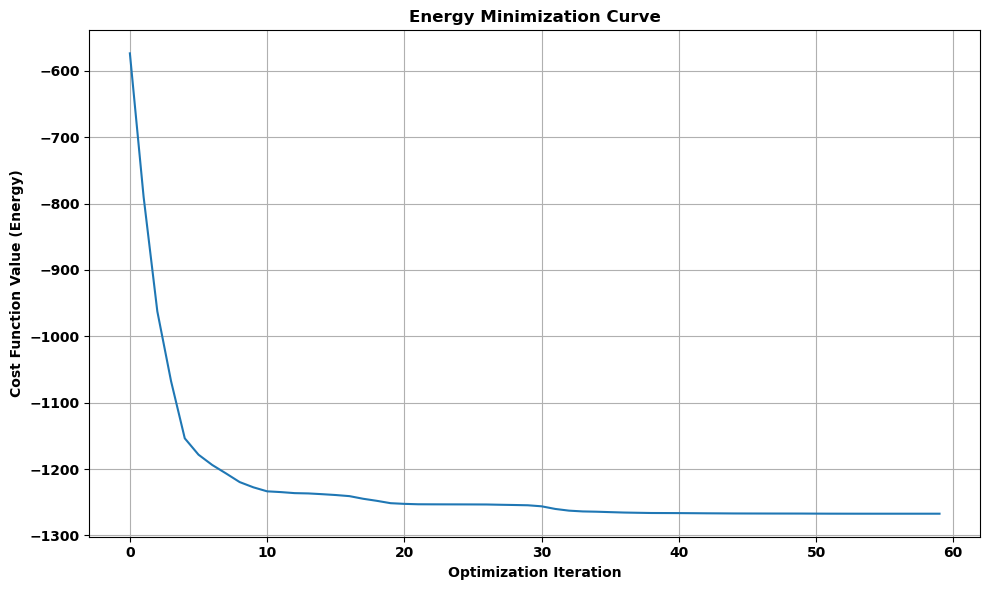

In [172]:
# Initialize variable parameters
x0_interaction = np.zeros(len(variable_params))  # All zeros

# Create initial full parameter dictionary - THIS IS THE KEY CHANGE
all_params = static_params.copy()  # Start with static parameters
all_params.update(dict(zip(variable_params, x0_interaction)))  # Add variable parameters

cost_values = []
# Call minimize with args
result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    args=(all_params, ansatz_grn_ct1, interaction_observable, estimator, variable_params), # Pass all the arguments as a tuple
    method="L-BFGS-B",
    callback=lambda xk: cost_values.append(cost_func_wrapper(xk, all_params, ansatz_grn_ct1, interaction_observable, estimator, variable_params))
)

print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_variable_parameters = result_interaction_bfgs.x

# Update the full parameter dictionary with optimized variable parameters
for param, value in zip(variable_params, optimized_variable_parameters):
    all_params[param] = value

df = pd.DataFrame(list(all_params.items()), columns=['Parameter', 'Value'])
df_nonzero = df[abs(df.Value) >= 0.01]
#print(df_nonzero)

import matplotlib.pyplot as plt

# Plot the cost function values
plt.figure(figsize=(10, 6))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

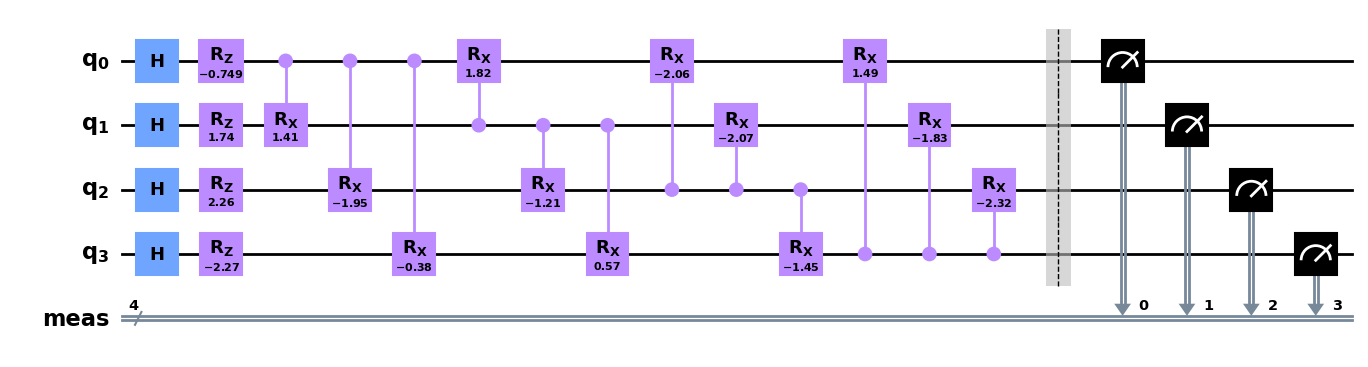

In [173]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
#from qiskit.primitives import SamplerV2  as Sampler  # Import Sampler
#from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp, Statevector
#from qiskit_aer import AerSimulator
#from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Use AerSimulator
sampler = StatevectorSampler()
# Bind the optimized parameters to the circuit
bound_circuit = ansatz_grn_ct1.copy()
bound_circuit.assign_parameters(all_params, inplace=True)
bound_circuit.measure_all() # Add measurement to all the qubits 
bound_circuit.draw(output="mpl", style="clifford", fold=40)

The number of bitstrings is: 1024
The counts are: {'0110': 643, '1111': 103, '1000': 52, '0000': 58, '1110': 17, '0111': 20, '1001': 32, '0001': 40, '0011': 17, '1010': 30, '0100': 10, '0010': 2}


C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_26548\2056871121.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, title="Quantum Sampler Results").show()


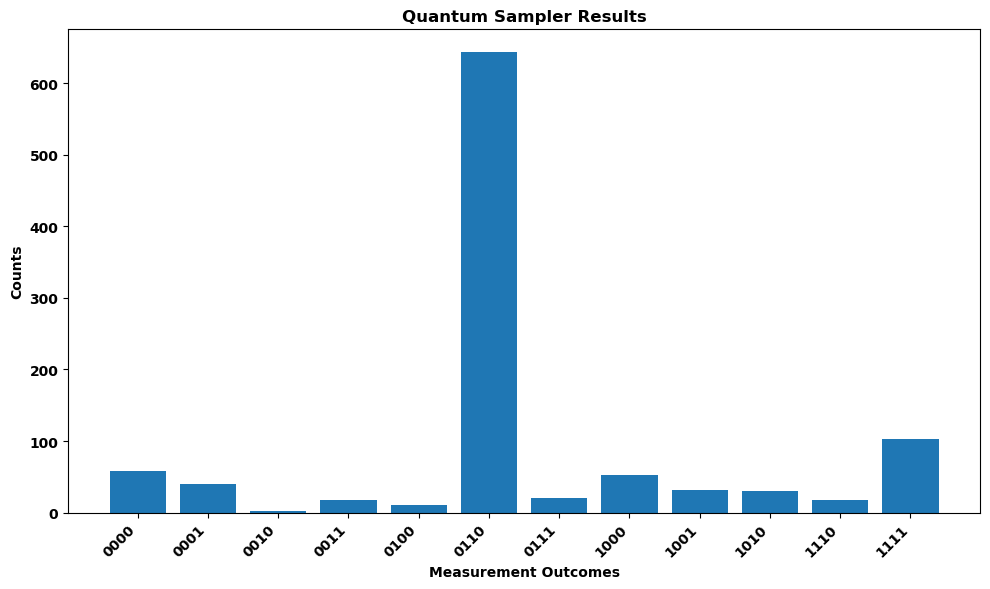

{'0110': 643, '1111': 103, '1000': 52, '0000': 58, '1110': 17, '0111': 20, '1001': 32, '0001': 40, '0011': 17, '1010': 30, '0100': 10, '0010': 2}


In [174]:
# Run the quantum sampler
job = sampler.run( [bound_circuit], shots=1024 )  # Adjust shots as needed
pub_result = job.result()[0]
data_pub = pub_result.data
# Access bitstring for the classical register "meas"
bitstrings = data_pub.meas.get_bitstrings()
print(f"The number of bitstrings is: {len(bitstrings)}")
# Get counts for the classical register "meas"
counts = data_pub.meas.get_counts()
print(f"The counts are: {counts}")

# Plot the histogram
plot_histogram(counts, title="Quantum Sampler Results").show()

# If you want to use matplotlib directly for more customization
# Convert counts to list for plotting
sorted_counts = dict(sorted(counts.items()))
x_labels = list(sorted_counts.keys())
y_values = list(sorted_counts.values())

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(x_labels, y_values)
plt.xlabel("Measurement Outcomes")
plt.ylabel("Counts")
plt.title("Quantum Sampler Results")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Print the counts
print(counts)

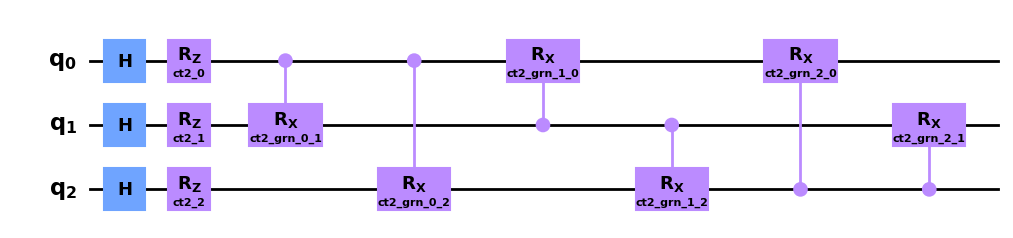

In [107]:
import matplotlib.pyplot as plt
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
import numpy as np

ng_ct2 = len(gl_recv)

ansatz_grn_ct2 = QuantumCircuit(ng_ct2, name="CT2_GRN_Ansatz")

params_ct2 = [Parameter(rf'ct2_{i}') for i in range(ng_ct2)]
# Apply Hadamard gates and RY rotations (gene activation probabilities)
for i in range(ng_ct2):
    ansatz_grn_ct2.h(i)
    ansatz_grn_ct2.rz(params_ct2[i], i)

# # Activation layer
# act_ct2 = [Parameter(rf'act_ct2_{i}') for i in range(ng_ct2)]
# for i in range(ng_ct2):
#     ansatz_grn_ct2.rz(act_ct2[i], i)

for i in range(ng_ct2):
    for j in range(ng_ct2):
        if i != j:
            param_name = f'ct2_grn_{i}_{j}'
            param = Parameter(param_name)
            ansatz_grn_ct2.crx(param, i, j)


ansatz_grn_ct2.draw(output="mpl", style="clifford", fold=40)

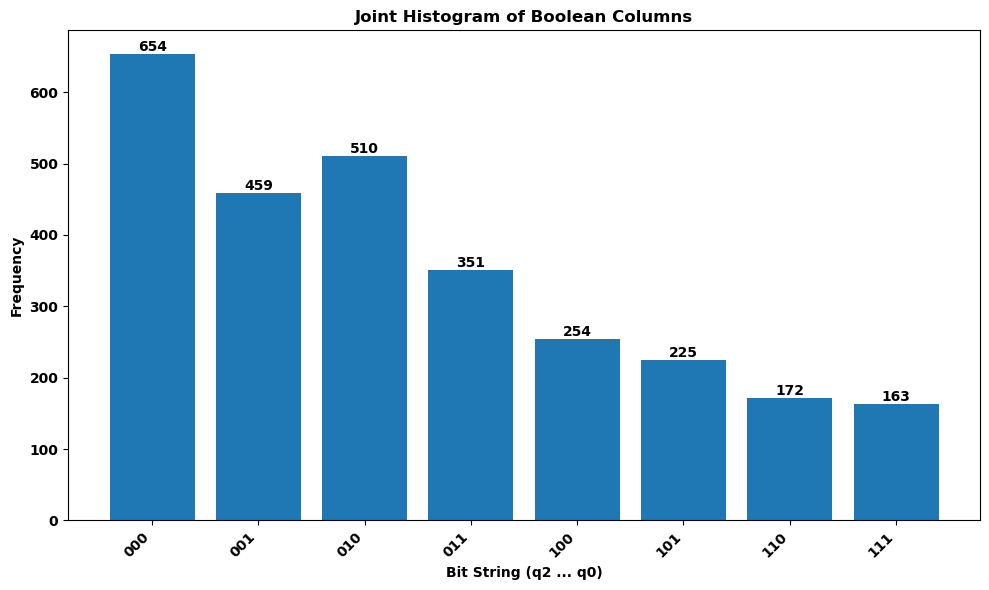

Joint Counts: Counter({'000': 654, '010': 510, '100': 459, '110': 351, '001': 254, '101': 225, '011': 172, '111': 163})
Bit Strings: ['000', '001', '010', '011', '100', '101', '110', '111']


In [108]:
# Example Usage (assuming Xct2 is defined):
Xct2bool = Xct2 > 0  # Create boolean array

joint_counts, bit_strings = create_joint_histogram(Xct2bool)

num_qubits = Xct2bool.shape[1]  # Get the number of qubits (important!)
plot_joint_histogram(joint_counts, num_qubits, reverse_bits=True)  # Pass num_qubits

print("Joint Counts:", joint_counts)
print("Bit Strings:", bit_strings)

In [23]:
num_features = Xct2bool.shape[1]  # Get the number of features dynamically

interaction_observable = create_interaction_observable_from_histogram(joint_counts, num_features, min_ones = 1)
print("Interaction observable from histogram:", interaction_observable)

Interaction observable from histogram: SparsePauliOp(['ZIZ', 'IZI', 'ZII', 'IZZ', 'ZZI', 'ZZZ', 'IIZ'],
              coeffs=[-225.+0.j, -510.+0.j, -459.+0.j, -172.+0.j, -351.+0.j, -163.+0.j,
 -254.+0.j])


In [24]:
static_params2, variable_params2 = create_parameter_dictionaries(ansatz_grn_ct2, ct2_percentages)

print("Static Parameters:", static_params2)
print("Variable Parameters:", variable_params2)

Static Parameters: {Parameter(ct2_0): -0.39754443622183616, Parameter(ct2_1): -0.4016010121016509, Parameter(ct2_2): -1.1764070051462494}
Variable Parameters: [Parameter(ct2_grn_0_1), Parameter(ct2_grn_0_2), Parameter(ct2_grn_1_0), Parameter(ct2_grn_1_2), Parameter(ct2_grn_2_0), Parameter(ct2_grn_2_1)]


In [25]:
# Initialize variable parameters
x0_interaction = np.zeros(len(variable_params2))  # All zeros

# Create initial full parameter dictionary - THIS IS THE KEY CHANGE
all_params2 = static_params2.copy()  # Start with static parameters
all_params2.update(dict(zip(variable_params2, x0_interaction)))  # Add variable parameters
all_params2

{Parameter(ct2_0): -0.39754443622183616,
 Parameter(ct2_1): -0.4016010121016509,
 Parameter(ct2_2): -1.1764070051462494,
 Parameter(ct2_grn_0_1): 0.0,
 Parameter(ct2_grn_0_2): 0.0,
 Parameter(ct2_grn_1_0): 0.0,
 Parameter(ct2_grn_1_2): 0.0,
 Parameter(ct2_grn_2_0): 0.0,
 Parameter(ct2_grn_2_1): 0.0}

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -286.63470583526976
        x: [-1.693e+00 -1.556e+00  9.338e-01 -2.236e+00  9.659e-01
             1.625e+00]
      nit: 19
      jac: [-6.821e-05  7.390e-05 -1.137e-05 -5.684e-06  0.000e+00
            -2.274e-05]
     nfev: 147
     njev: 21
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


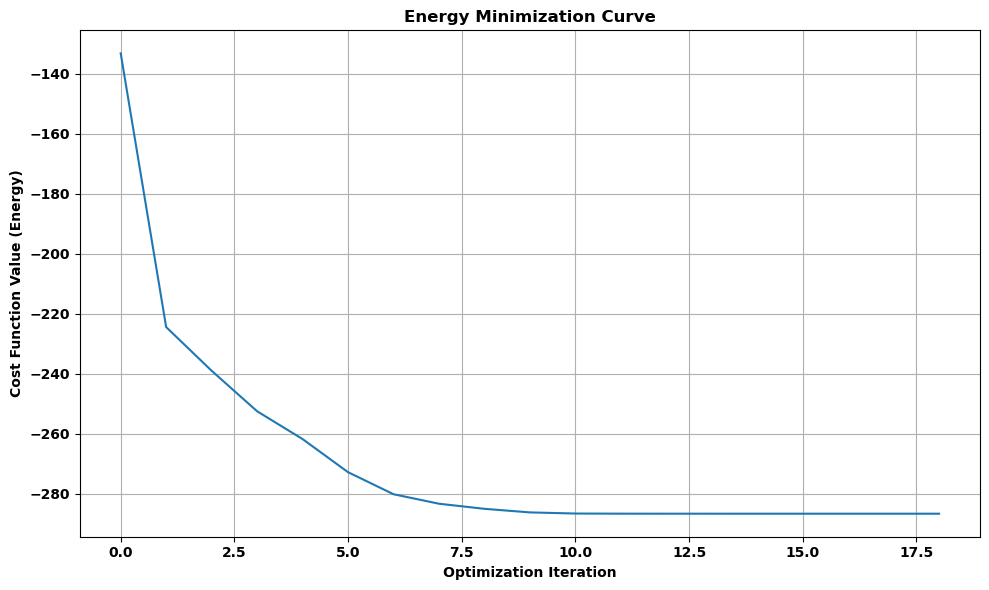

In [26]:
cost_values = []
# Call minimize with args, using a lambda for the callback
result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    args=(all_params2, ansatz_grn_ct2, interaction_observable, estimator, variable_params2),
    method="L-BFGS-B",
    callback=lambda xk: cost_values.append(cost_func_wrapper(xk, all_params2, ansatz_grn_ct2, interaction_observable, estimator, variable_params2))
)

print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_variable_parameters = result_interaction_bfgs.x

# Update the full parameter dictionary with optimized variable parameters
for param, value in zip(variable_params2, optimized_variable_parameters):
    all_params2[param] = value

df = pd.DataFrame(list(all_params2.items()), columns=['Parameter', 'Value'])
df_nonzero = df[abs(df.Value) >= 0.01]
#print(df_nonzero)

import matplotlib.pyplot as plt

# Plot the cost function values
plt.figure(figsize=(10, 6))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

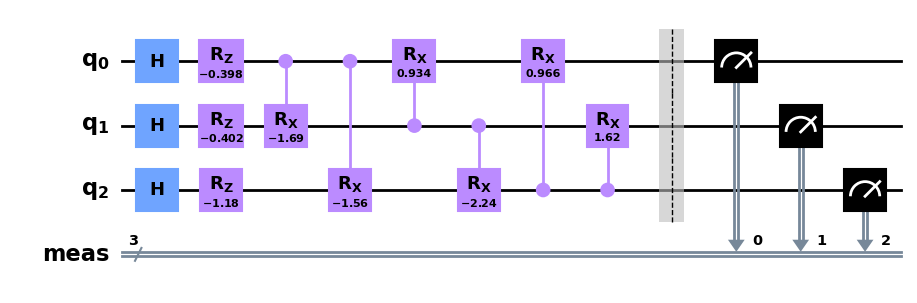

In [27]:
# Use AerSimulator
sampler = StatevectorSampler()
# Bind the optimized parameters to the circuit
bound_circuit = ansatz_grn_ct2.copy()
bound_circuit.assign_parameters(all_params2, inplace=True)
bound_circuit.measure_all() # Add measurement to all the qubits 
bound_circuit.draw(output="mpl", style="clifford", fold=40)

The number of bitstrings is: 512
The counts are: {'010': 134, '000': 51, '100': 141, '001': 170, '011': 5, '111': 7, '101': 3, '110': 1}


C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_26548\1765730973.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, title="Quantum Sampler Results").show()


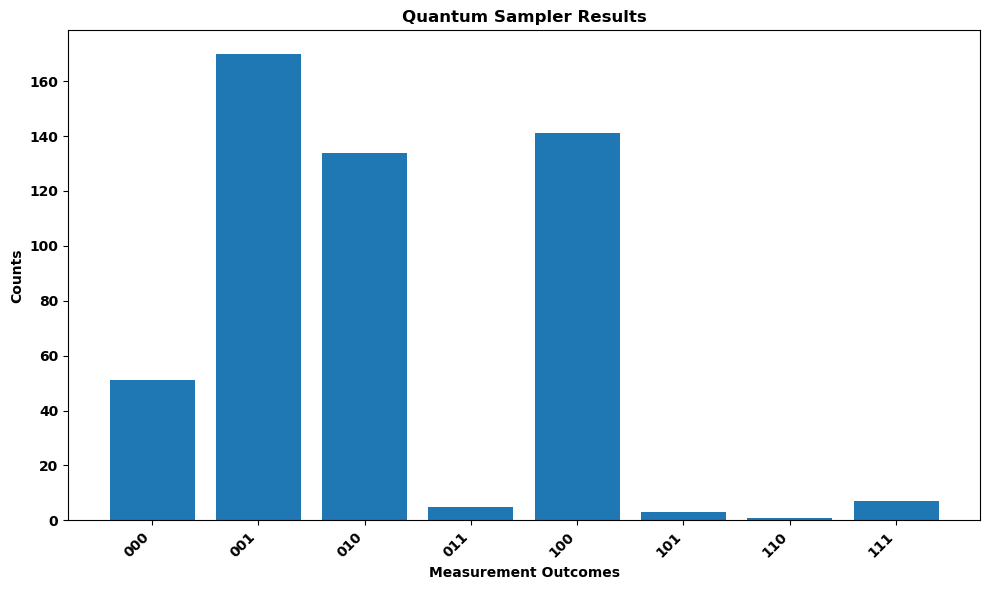

{'010': 134, '000': 51, '100': 141, '001': 170, '011': 5, '111': 7, '101': 3, '110': 1}


In [28]:
# Run the quantum sampler
job = sampler.run( [bound_circuit], shots=512 )  # Adjust shots as needed
pub_result = job.result()[0]
data_pub = pub_result.data
# Access bitstring for the classical register "meas"
bitstrings = data_pub.meas.get_bitstrings()
print(f"The number of bitstrings is: {len(bitstrings)}")
# Get counts for the classical register "meas"
counts = data_pub.meas.get_counts()
print(f"The counts are: {counts}")

# Plot the histogram
plot_histogram(counts, title="Quantum Sampler Results").show()

# If you want to use matplotlib directly for more customization
# Convert counts to list for plotting
sorted_counts = dict(sorted(counts.items()))
x_labels = list(sorted_counts.keys())
y_values = list(sorted_counts.values())

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(x_labels, y_values)
plt.xlabel("Measurement Outcomes")
plt.ylabel("Counts")
plt.title("Quantum Sampler Results")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Print the counts
print(counts)

In [110]:
# def create_interaction_observable_general(interactions, num_features):
#     """Creates a SparsePauliOp observable for generalized interactions.

#     Args:
#         interactions: A dictionary where keys are tuples of node indices 
#                      (e.g., (0, 1), (0, 0, 2), (0, 1, 2, 3)) and 
#                      values are the corresponding interaction strengths.
#         num_features: The total number of qubits.

#     Returns:
#         A SparsePauliOp observable.
#     """
#     interaction_strength_list = []
#     for nodes, strength in interactions.items():
#         pauli_string = ""
#         for i in range(num_features):
#             if i in nodes:  # Check if the current qubit is in the interaction
#                 pauli_string += "Z"
#             else:
#                 pauli_string += "I"
#         interaction_strength_list.append((pauli_string, strength))

#     interaction_observable = SparsePauliOp.from_list(interaction_strength_list)
#     return interaction_observable


# # Define your custom interactions with strengths
# interactions = {
#     (0,): -1,       # Interaction on qubit 0
#     (0, 1): -1,     # Interaction between qubits 0 and 1
#     (0, 2): -1,     # Interaction between qubits 0 and 2
#     (1, 2, 3): -1,  # Interaction between qubits 1, 2, and 3
#     (0, 0): -1, #Interaction on qubit 0
#     (0, 0, 0, 0): -1 #Interaction on qubit 0
# }

# interaction_observable = create_interaction_observable_general(interactions, ng_ct1)
# print("Interaction observable custom: ", interaction_observable)